<a href="https://www.kaggle.com/code/clemwo/time-series-understanding-autocorrelation?scriptVersionId=239289507" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

✨✨This notebook is the **1st** notebook of my **🧠 Timeseries Series ⏱️**, where I am trying to dive into time series and the mathematics of common techniques. 

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.style.use('ggplot')

/kaggle/input/time-series-starter-dataset/Month_Value_1.csv


# 🧠Time Series ⏱️ Understanding Autocorrelation🌀

In this notebook we dive into the mathematics autocorrelation, partial autocorrelation and how to create respective plots from scratch, like the Partial Auto Correlation Function. The objective is to understand autocorrelations and it's math and fully grasp plots which we normally use for time series analysis. 

# Global Variables & Settings

In [2]:
RANDOM_SEED = 42
FACECOLOR = '#fcf7e5'

np.random.seed(RANDOM_SEED)

# Reading the Data

In [3]:
data = pd.read_csv('/kaggle/input/time-series-starter-dataset/Month_Value_1.csv')
print(f"Rows: {data.shape[0]:,}")
print(f"Cols: {data.shape[1]:,}")
pd.set_option('display.float_format', '{:,.2f}'.format)
data.head(5)

Rows: 96
Cols: 5


,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,"16,010,072.12","12,729.00","1,257.76","30,024,676.00"
1,01.02.2015,"15,807,587.45","11,636.00","1,358.51","30,024,676.00"
2,01.03.2015,"22,047,146.02","15,922.00","1,384.70","30,024,676.00"
3,01.04.2015,"18,814,583.29","15,227.00","1,235.61","30,024,676.00"
4,01.05.2015,"14,021,479.61","8,620.00","1,626.62","30,024,676.00"


In [4]:
data.dtypes

Period                                       object
Revenue                                     float64
Sales_quantity                              float64
Average_cost                                float64
The_average_annual_payroll_of_the_region    float64
dtype: object

# Pre-Processing

In [5]:
data = data.dropna(subset=['Revenue'])

Let's convert the time column `Period` from type object to an actual datetime. 

In [6]:
data['Period'] = pd.to_datetime(data['Period'], dayfirst=True)
data['Period'][:5]

0   2015-01-01
1   2015-02-01
2   2015-03-01
3   2015-04-01
4   2015-05-01
Name: Period, dtype: datetime64[ns]

For time series data we should set the time column as the index.

In [7]:
data.set_index('Period', inplace=True)
data['Year'] = data.index.year

In [8]:
print(data.index.min())
print(data.index.max())

2015-01-01 00:00:00
2020-04-01 00:00:00


# Exploratory Data Analysis

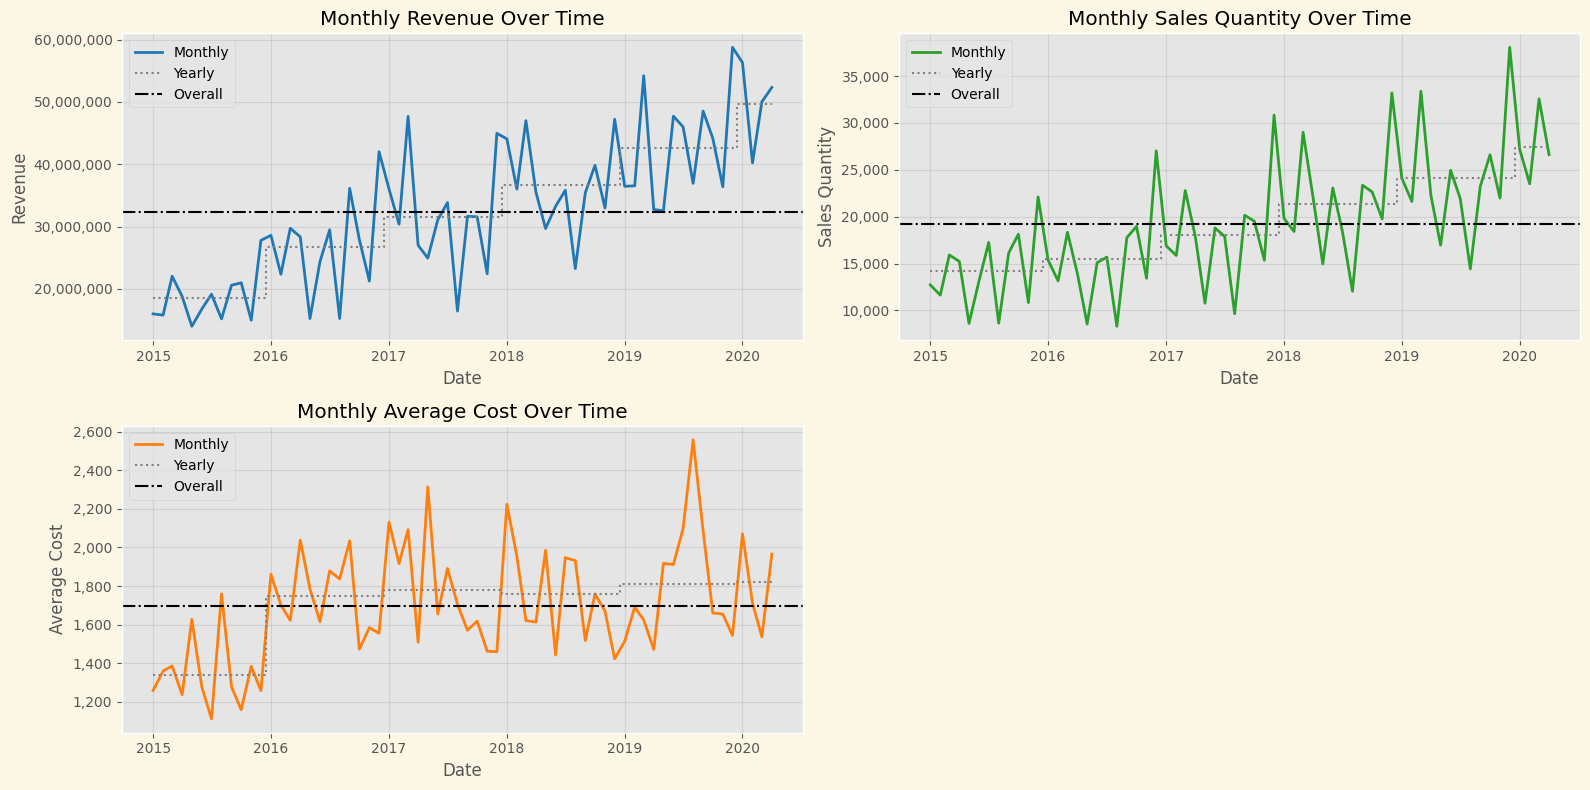

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), facecolor=FACECOLOR)
axs = axs.flatten()

def plot_metric(ax, column, color, title, ylabel):
    yearly_avg = data.groupby('Year')[column].mean()
    step_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='MS')
    step_values = step_dates.to_series().dt.year.map(yearly_avg)
    overall_avg = data[column].mean()

    ax.plot(data.index, data[column], color=color, linewidth=2, label='Monthly')
    ax.step(step_dates, step_values, where='mid', linestyle=':', color='gray', linewidth=1.5, label='Yearly')
    ax.axhline(y=overall_avg, color='black', linestyle='-.', linewidth=1.5, label='Overall')

    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.2, color='grey')

    formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
    ax.yaxis.set_major_formatter(formatter)
    ax.legend()

plot_metric(axs[0], 'Revenue', 'tab:blue', 'Monthly Revenue Over Time', 'Revenue')
plot_metric(axs[1], 'Sales_quantity', 'tab:green', 'Monthly Sales Quantity Over Time', 'Sales Quantity')
plot_metric(axs[2], 'Average_cost', 'tab:orange', 'Monthly Average Cost Over Time', 'Average Cost')

# Hide the unused 4th subplot
axs[3].axis('off')

plt.tight_layout()
plt.show()

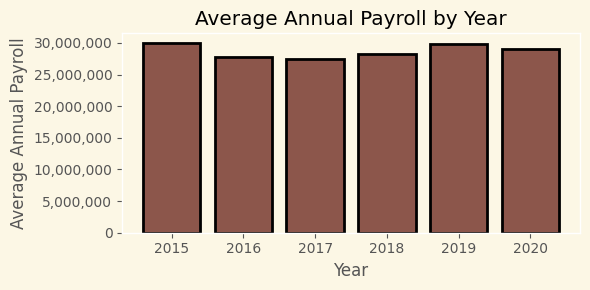

In [10]:
yearly_avg_payroll = data.groupby('Year')['The_average_annual_payroll_of_the_region'].mean()

fig = plt.figure(figsize=(6, 3), facecolor=FACECOLOR)
ax = fig.add_subplot(111, facecolor=FACECOLOR)

ax.bar(yearly_avg_payroll.index.astype(str), yearly_avg_payroll.values, 
       color='tab:brown', edgecolor='black', linewidth=2)

ax.set_title('Average Annual Payroll by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Average Annual Payroll')
ax.grid(False)

formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
ax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

# Seasonal Plots

In [11]:
data['Month_name'] = data.index.strftime('%b')
data['Month_num'] = data.index.month
data['Year'] = data.index.year

## Year-over-Year and Month-over-Month

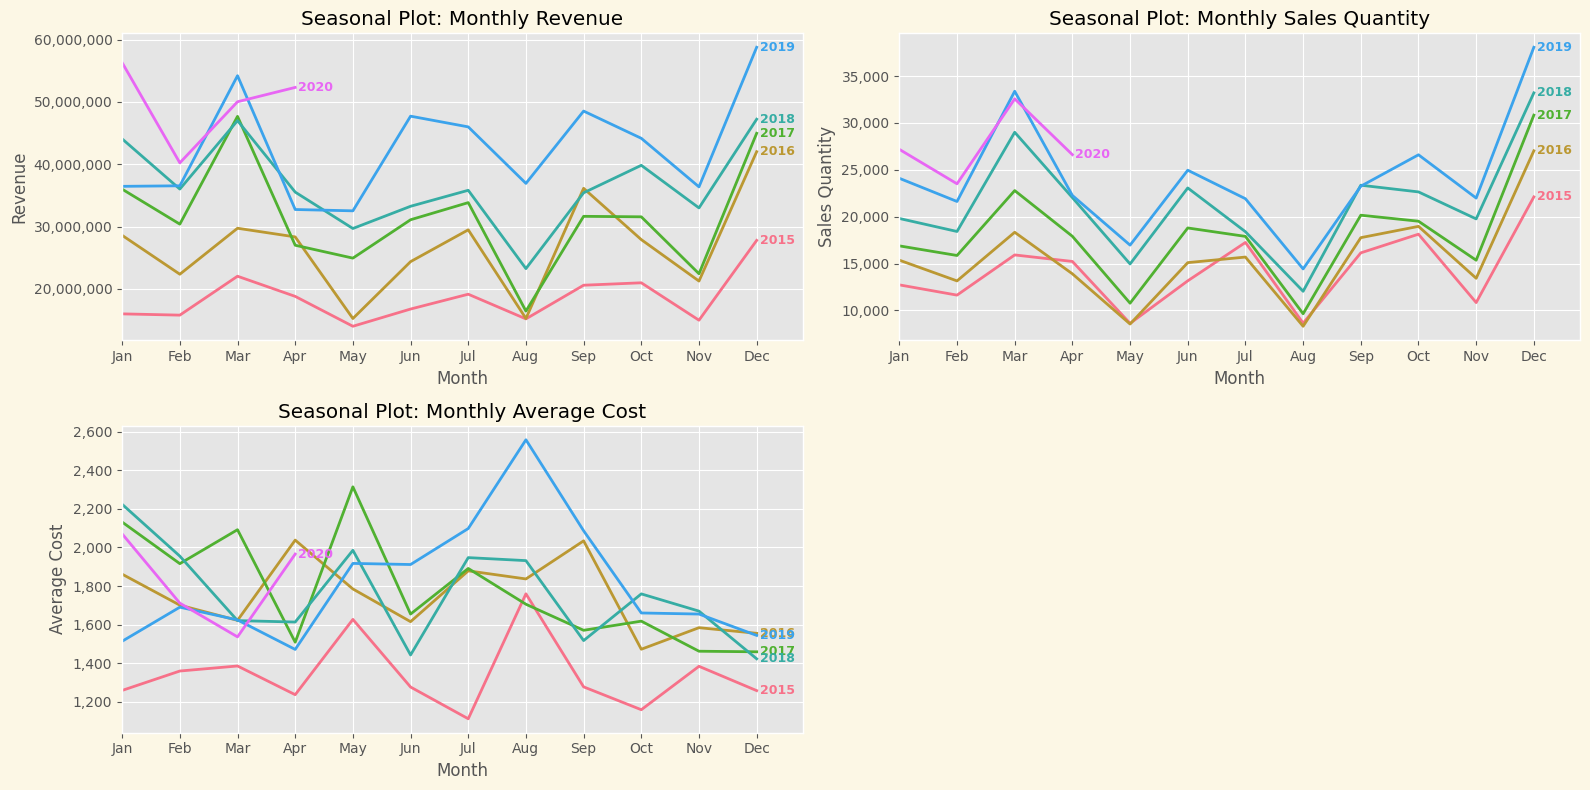

In [12]:
unique_years = data['Year'].unique()
year_palette = sns.color_palette("husl", n_colors=len(unique_years))
min_year = unique_years.min()

fig, axs = plt.subplots(2, 2, figsize=(16, 8), facecolor=FACECOLOR)

def seasonal_lineplot(ax, column, title, ylabel, color_palette):
    sns.lineplot(
        data=data,
        x='Month_num',
        y=column,
        hue='Year',
        palette=color_palette,
        linewidth=2,
        legend=False,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel(ylabel)
    ax.set_xlim(1, 12.8)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
    ax.yaxis.set_major_formatter(formatter)

    for year, subset in data.groupby("Year"):
        subset_sorted = subset.sort_values("Month_num")
        subset_sorted = subset_sorted.dropna(subset=["Month_num", column])
        if subset_sorted.empty:
            continue
        x_pos = subset_sorted["Month_num"].iloc[-1]
        y_pos = subset_sorted[column].iloc[-1]
        if pd.notnull(y_pos):
            ax.text(
                x=x_pos + 0.05,
                y=y_pos,
                s=str(year),
                fontsize=9,
                weight="bold",
                color=color_palette[year - min_year],
                verticalalignment='center'
            )

seasonal_lineplot(axs[0, 0], 'Revenue', 'Seasonal Plot: Monthly Revenue', 'Revenue', year_palette)
seasonal_lineplot(axs[0, 1], 'Sales_quantity', 'Seasonal Plot: Monthly Sales Quantity', 'Sales Quantity', year_palette)
seasonal_lineplot(axs[1, 0], 'Average_cost', 'Seasonal Plot: Monthly Average Cost', 'Average Cost', year_palette)

axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

$\textbf{Revenue}$

- We clearly see: the revenue is increasing year-over-year. There is a **large jump in revenue in December each year**. The graph also shows a drop in data after April 2020. This is likely due to the world-wide Corona crisis.

$\textbf{Sales Quantity}$

- We observe a similar pattern as for the revenue. Here, the year-over-year seasonal behavior is even more similar and the only difference is a higher sales count year-over-year, but the seasonal pattern stays the same.

$\textbf{Average Cost}$

- The average cost does not show as clear of a seasonal year-over-year pattern as we saw for revenue and sales. However, seasonality is still visible. 

In [13]:
data['year'] = data.index.year
data['month'] = data.index.strftime('%B')
data['month'] = pd.Categorical(
    data['month'],
    categories=[
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ],
    ordered=True
)

An alternative plot that emphasises the seasonal patterns is where the data for each season are collected together in separate mini time plots ([source](https://otexts.com/fpppy/nbs/02-graphics.html)).

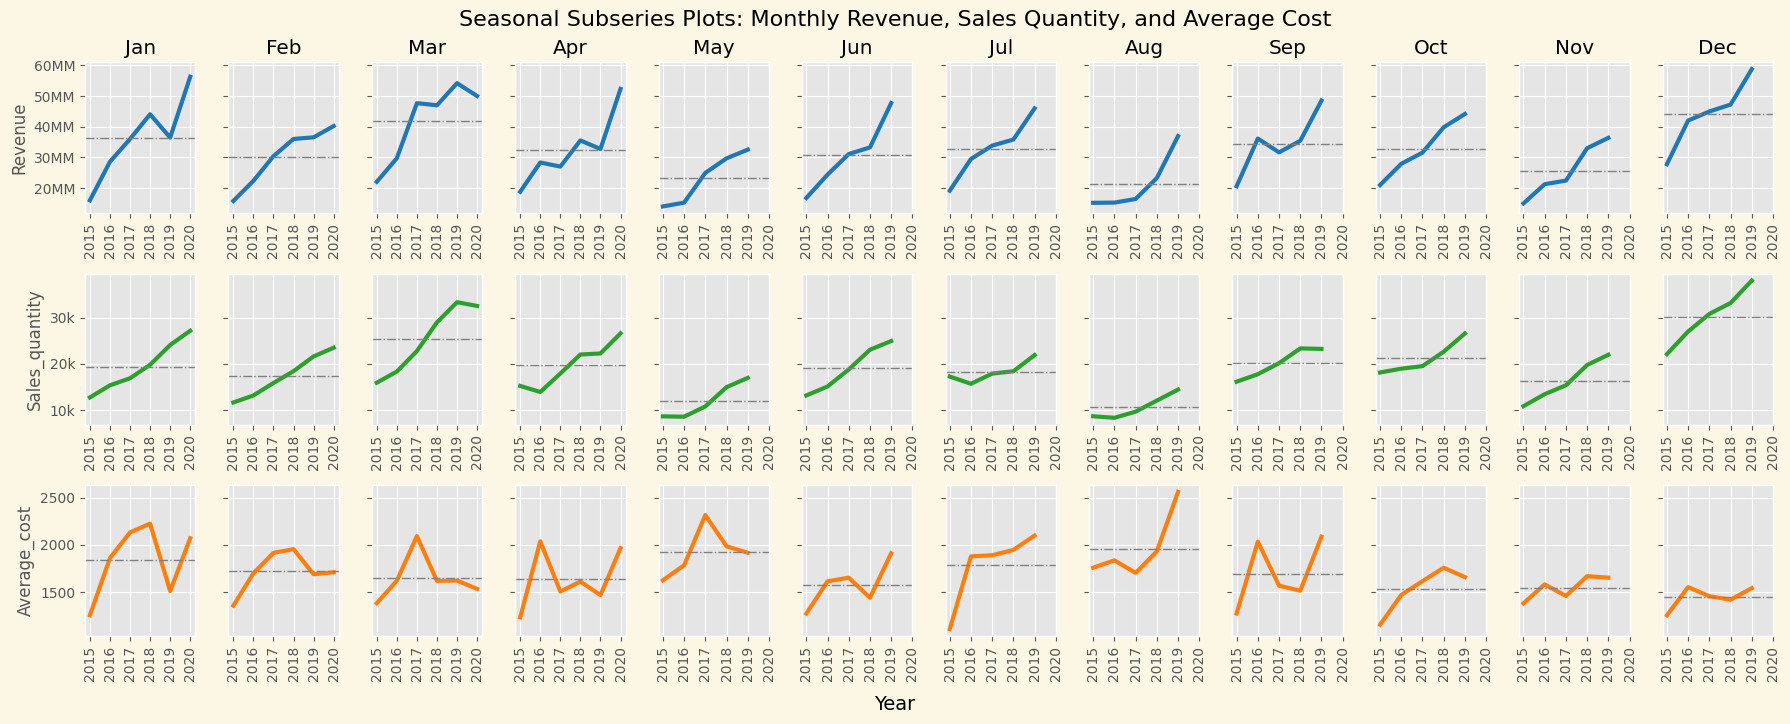

In [14]:
all_years = sorted(data['year'].unique())
months = data['month'].cat.categories
variables = [
    ('Revenue', 'tab:blue'),
    ('Sales_quantity', 'tab:green'),
    ('Average_cost', 'tab:orange'),
]

fig, axes = plt.subplots(nrows=3, ncols=12, figsize=(18, 7), sharey='row', facecolor=FACECOLOR)

for row, (var, color) in enumerate(variables):
    for col, month in enumerate(months):
        month_data = data.query("month == @month")
        mean_val = month_data[var].mean()

        ax = axes[row, col]
        ax.plot(month_data['year'], month_data[var], color=color, linewidth=3)
        ax.axhline(mean_val, color='grey', linestyle='-.', linewidth=1)

        if row == 0:
            ax.set_title(month[:3])
        if col == 0:
            ax.set_ylabel(var)
            ax.tick_params(labelleft=True)
        
            # Format y-ticks by row
            if row == 0:
                formatter = FuncFormatter(lambda x, _: f'{x/1e6:.0f}MM')
            if row == 1:
                formatter = FuncFormatter(lambda x, _: f'{x/1e3:.0f}k')
            if row in [0,1]: 
                ax.yaxis.set_major_formatter(formatter)
        else:
            ax.tick_params(labelleft=False)
        
        ax.set_xticks(all_years)
        ax.tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("Seasonal Subseries Plots: Monthly Revenue, Sales Quantity, and Average Cost", fontsize=16)
fig.text(0.5, -0.02, "Year", ha="center", fontsize=14)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

The grey horizontal lines indicate the means for each month. This plot enables us to see the underlying seasonal pattern even more clearly than in the previous plot. As before, but more clearly, we observe a constant year-over-year increase in revenue. Even clearer we see that this pattern holds true for each and every month.

## Quarter-over-Quarter

In [15]:
data['Quarter'] = "Q" + data.index.quarter.astype(str)
data['Year'] = data.index.year

data['Quarter'] = pd.Categorical(
    data['Quarter'],
    categories=["Q1", "Q2", "Q3", "Q4"],
    ordered=True
)

all_years = sorted(data['Year'].unique())
quarters = data['Quarter'].cat.categories

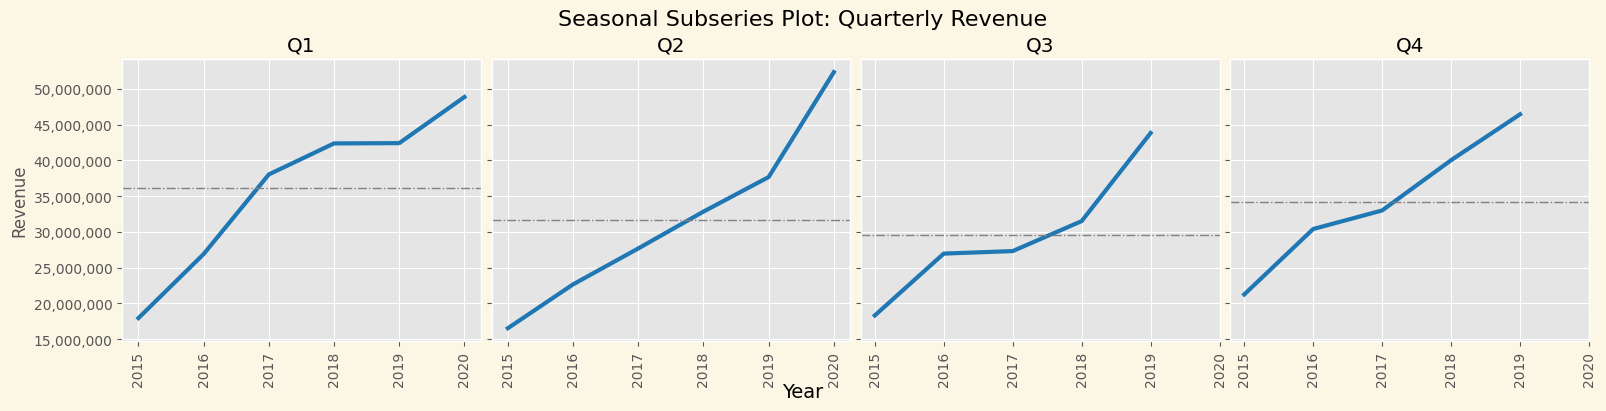

In [16]:
quarterly_avg = data.groupby(['Year', 'Quarter'])['Revenue'].mean().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey=True, facecolor=FACECOLOR)

for i, quarter in enumerate(quarters):
    quarter_data = quarterly_avg[quarterly_avg['Quarter'] == quarter]
    mean_val = quarter_data['Revenue'].mean()

    axes[i].plot(quarter_data['Year'], quarter_data['Revenue'], color='tab:blue', linewidth=3)
    axes[i].axhline(mean_val, color='grey', linestyle='-.', linewidth=1)
    axes[i].set_title(quarter)
    axes[i].set_xticks(all_years)
    axes[i].tick_params(axis='x', rotation=90)

    if i == 0:
        axes[i].set_ylabel("Revenue")
        formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
        axes[i].yaxis.set_major_formatter(formatter)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Adjust subplot positions to reduce horizontal gaps
for ax in axes:
    pos = ax.get_position()
    ax.set_position([pos.x0 - 0.005, pos.y0, pos.width + 0.01, pos.height])

fig.suptitle("Seasonal Subseries Plot: Quarterly Revenue", fontsize=16)
fig.text(0.5, 0.01, "Year", ha="center", fontsize=14)
plt.show()

## Scatter plots

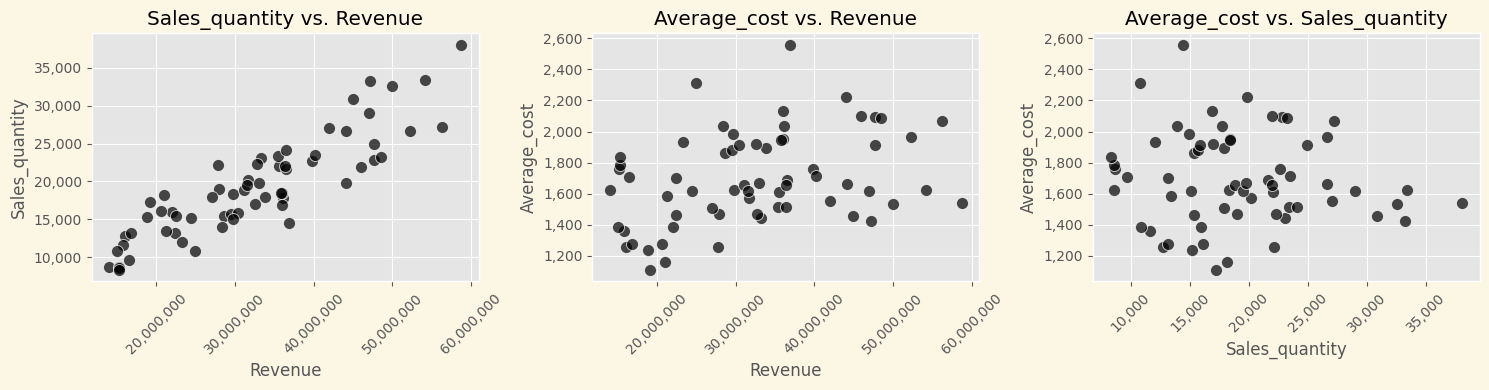

In [17]:
from itertools import combinations

vars_of_interest = ['Revenue', 'Sales_quantity', 'Average_cost']
combos = list(combinations(vars_of_interest, 2))

fig, axs = plt.subplots(1, len(combos), figsize=(5 * len(combos), 4), facecolor=FACECOLOR)

for ax, (x_var, y_var) in zip(axs, combos):
    sns.scatterplot(data=data, x=x_var, y=y_var, color='black', 
                    s=75, alpha=0.7, ax=ax)
    ax.set_title(f"{y_var} vs. {x_var}")
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)

    ax.tick_params(axis='x', rotation=45)

    formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

As we could have already guessed by previous chapters insights, Revenue and Sales have a clear correlation. This also makes intuitively sense. However, average cost is not correlation with any of these two. Let's validate this by taking a look at the correlation matrix.

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


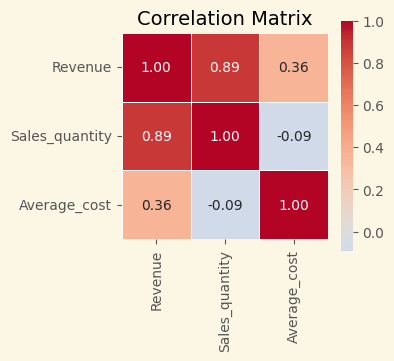

In [18]:
corr_matrix = data[vars_of_interest].corr()

plt.figure(figsize=(4, 4), facecolor=FACECOLOR)
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)

plt.title("Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.show()

# Autocorrelation